In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from collections import Counter
from scipy import stats
# warning library
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import collections

In [4]:
masks = pd.read_csv(r"C:\Users\jdgoe\Downloads\OxCGRT_compact_national_v1.csv") #https://ourworldindata.org/grapher/face-covering-policies-covid?tab=table

In [5]:
masks.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1M_School closing', 'C1M_Flag',
       'C2M_Workplace closing', 'C2M_Flag', 'C3M_Cancel public events',
       'C3M_Flag', 'C4M_Restrictions on gatherings', 'C4M_Flag',
       'C5M_Close public transport', 'C5M_Flag',
       'C6M_Stay at home requirements', 'C6M_Flag',
       'C7M_Restrictions on internal movement', 'C7M_Flag',
       'C8EV_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6M_Facial Coverings', 'H6M_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'H8M_Protection of elderly people', 'H8M_Flag',
       'V1_Vaccine Prioritisation (summary)',
       'V2A_Vaccine Availability (summary)',
      

In [6]:
masks = masks.reindex(columns=['CountryName', 'CountryCode', 'Date', 'H6M_Facial Coverings', 'C1M_School closing', 'E1_Income support'])

In [7]:
# masks_2 = masks[masks['Date'] > 20200401]
masks_2 = masks[masks['Date'] > 20200401]

In [8]:
# Assuming masks_2 is your DataFrame and you have a list of columns to iterate over
columns_to_iterate = ['H6M_Facial Coverings', 'C1M_School closing', 'E1_Income support']  # Replace with your actual column names

for column in columns_to_iterate:
    # Calculate the mean for each country for the current column
    mean_values = masks_2.groupby('CountryName')[column].mean()

    # Map these mean values back to the DataFrame
    masks_2[f'Average {column} Stringency'] = masks_2['CountryName'].map(mean_values)

# Display the updated DataFrame
print(masks_2)

       CountryName CountryCode      Date  H6M_Facial Coverings  \
92           Aruba         ABW  20200402                   0.0   
93           Aruba         ABW  20200403                   0.0   
94           Aruba         ABW  20200404                   0.0   
95           Aruba         ABW  20200405                   0.0   
96           Aruba         ABW  20200406                   0.0   
...            ...         ...       ...                   ...   
202755    Zimbabwe         ZWE  20221227                   3.0   
202756    Zimbabwe         ZWE  20221228                   3.0   
202757    Zimbabwe         ZWE  20221229                   3.0   
202758    Zimbabwe         ZWE  20221230                   3.0   
202759    Zimbabwe         ZWE  20221231                   3.0   

        C1M_School closing  E1_Income support  \
92                     3.0                2.0   
93                     3.0                2.0   
94                     3.0                2.0   
95         

In [11]:
masks_2.columns

Index(['CountryName', 'CountryCode', 'Date', 'H6M_Facial Coverings',
       'C1M_School closing', 'E1_Income support',
       'Average H6M_Facial Coverings Stringency',
       'Average C1M_School closing Stringency',
       'Average E1_Income support Stringency'],
      dtype='object')

In [12]:
masks_2 = masks_2.reindex(columns=['CountryName', 'CountryCode', 'Average H6M_Facial Coverings Stringency',
       'Average C1M_School closing Stringency',
       'Average E1_Income support Stringency',
       ])
masks_2 = masks_2.drop_duplicates('CountryName')

In [13]:
# https://ourworldindata.org/grapher/cumulative-excess-deaths-per-million-covid?tab=table&time=earliest..latest
death_rate = pd.read_csv(r"C:\Users\jdgoe\Downloads\cumulative-excess-deaths-per-million-covid (1).csv")

In [14]:
death_rate.columns

Index(['Entity', 'Code', 'Day', 'cum_excess_per_million_proj_all_ages'], dtype='object')

In [15]:
death_by_day = death_rate.groupby('Day')['cum_excess_per_million_proj_all_ages'].mean()

In [17]:
death_rate['Day'] = pd.to_datetime(death_rate['Day'])

In [18]:
# Target date
target_date = pd.to_datetime('2022-12-31')

# Function to get closest record
def get_closest_record_before_target(group):
    # Ensure group is sorted by date
    group = group.sort_values(by='Day', ascending=False)
    # Get rows on or before the target date
    filtered_group = group[group['Day'] <= target_date]
    # Return the first row (closest to target date)
    return filtered_group.head(1)

# Apply the function to each group
closest_records = death_rate.groupby('Entity', group_keys=False).apply(get_closest_record_before_target)

closest_records

,Entity,Code,Day,cum_excess_per_million_proj_all_ages
35,Albania,ALB,2022-12-31,5584.03300
56,Algeria,DZA,2020-12-31,1148.14250
80,Andorra,AND,2021-12-31,1773.40420
104,Antigua and Barbuda,ATG,2021-12-31,-654.30286
128,Argentina,ARG,2021-12-31,2901.88430
...,...,...,...,...
12019,United Arab Emirates,ARE,2021-12-31,386.49686
12175,United Kingdom,GBR,2022-12-25,2703.83280
12375,United States,USA,2022-12-25,3669.03470
12449,Uruguay,URY,2022-12-31,2126.09810


In [19]:
target_date2 = pd.to_datetime('2022-10-01')
closest_2 = closest_records[closest_records['Day'] >= target_date2]

In [20]:
df = pd.merge(closest_2, masks_2, left_on='Code', right_on='CountryCode', how='inner')
df

,Entity,Code,Day,cum_excess_per_million_proj_all_ages,CountryName,CountryCode,Average H6M_Facial Coverings Stringency,Average C1M_School closing Stringency,Average E1_Income support Stringency
0,Albania,ALB,2022-12-31,5584.03300,Albania,ALB,2.490040,1.292829,0.736056
1,Australia,AUS,2022-12-25,849.72516,Australia,AUS,2.143426,1.100598,0.361554
2,Austria,AUT,2022-12-25,2567.49220,Austria,AUT,2.313745,1.584661,2.000000
3,Azerbaijan,AZE,2022-12-31,3777.47600,Azerbaijan,AZE,1.927291,2.318725,0.688247
4,Barbados,BRB,2022-12-31,1115.58470,Barbados,BRB,2.495020,1.866534,0.661355
...,...,...,...,...,...,...,...,...,...
80,Turkey,TUR,2022-12-31,2693.92330,Turkey,TUR,3.135458,1.305777,0.959163
81,United Kingdom,GBR,2022-12-25,2703.83280,United Kingdom,GBR,2.243028,1.271912,1.089641
82,United States,USA,2022-12-25,3669.03470,United States,USA,2.879482,2.002988,0.919323
83,Uruguay,URY,2022-12-31,2126.09810,Uruguay,URY,1.609562,0.929283,1.070717


In [21]:
df.columns

Index(['Entity', 'Code', 'Day', 'cum_excess_per_million_proj_all_ages',
       'CountryName', 'CountryCode', 'Average H6M_Facial Coverings Stringency',
       'Average C1M_School closing Stringency',
       'Average E1_Income support Stringency'],
      dtype='object')

In [22]:
df2 = df.reindex(columns=['CountryName', 'cum_excess_per_million_proj_all_ages', 'Average H6M_Facial Coverings Stringency',
       'Average C1M_School closing Stringency',
       'Average E1_Income support Stringency',
       ])
df2

,CountryName,cum_excess_per_million_proj_all_ages,Average H6M_Facial Coverings Stringency,Average C1M_School closing Stringency,Average E1_Income support Stringency
0,Albania,5584.03300,2.490040,1.292829,0.736056
1,Australia,849.72516,2.143426,1.100598,0.361554
2,Austria,2567.49220,2.313745,1.584661,2.000000
3,Azerbaijan,3777.47600,1.927291,2.318725,0.688247
4,Barbados,1115.58470,2.495020,1.866534,0.661355
...,...,...,...,...,...
80,Turkey,2693.92330,3.135458,1.305777,0.959163
81,United Kingdom,2703.83280,2.243028,1.271912,1.089641
82,United States,3669.03470,2.879482,2.002988,0.919323
83,Uruguay,2126.09810,1.609562,0.929283,1.070717


In [23]:
df2 = df2.rename(columns={'cum_excess_per_million_proj_all_ages': 'Excess Mortality', 'CountryName': 'Country', 'Average H6M_Facial Coverings Stringency': 'Mask Policy Stringency', 'Average C1M_School closing Stringency': 'School Closing Stringency', 'Average E1_Income support Stringency': 'Income support'})
df2.sort_values('Excess Mortality', ascending=False)

,Country,Excess Mortality,Mask Policy Stringency,School Closing Stringency,Income support
8,Bulgaria,10165.96300,1.807769,1.203187,1.543825
65,Russia,8749.63700,2.194223,1.120518,0.861554
67,Serbia,8464.41200,2.247012,1.037849,1.541833
43,Lithuania,8358.04200,1.698207,1.025896,1.741036
6,Bosnia and Herzegovina,7126.26760,2.522908,1.346614,0.328685
...,...,...,...,...,...
54,New Zealand,-83.65968,1.862550,0.707171,1.212151
44,Luxembourg,-254.94089,2.041833,0.864542,0.937251
22,Faeroe Islands,-346.40503,0.496016,0.416335,0.541833
68,Seychelles,-546.97370,2.217131,1.475100,0.846614


In [24]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each column
for col in df2[['Mask Policy Stringency',
       'School Closing Stringency', 'Income support']]:
    df2 = remove_outliers(df2, col)

In [25]:
df2.sort_values('Excess Mortality', ascending=False)

,Country,Excess Mortality,Mask Policy Stringency,School Closing Stringency,Income support
8,Bulgaria,10165.96300,1.807769,1.203187,1.543825
65,Russia,8749.63700,2.194223,1.120518,0.861554
67,Serbia,8464.41200,2.247012,1.037849,1.541833
43,Lithuania,8358.04200,1.698207,1.025896,1.741036
6,Bosnia and Herzegovina,7126.26760,2.522908,1.346614,0.328685
...,...,...,...,...,...
52,Mongolia,211.21863,2.624502,1.602590,0.263944
54,New Zealand,-83.65968,1.862550,0.707171,1.212151
44,Luxembourg,-254.94089,2.041833,0.864542,0.937251
68,Seychelles,-546.97370,2.217131,1.475100,0.846614


<AxesSubplot:>

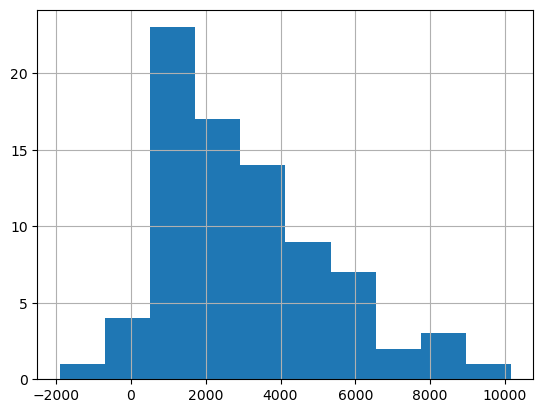

In [26]:
df2['Excess Mortality'].hist()

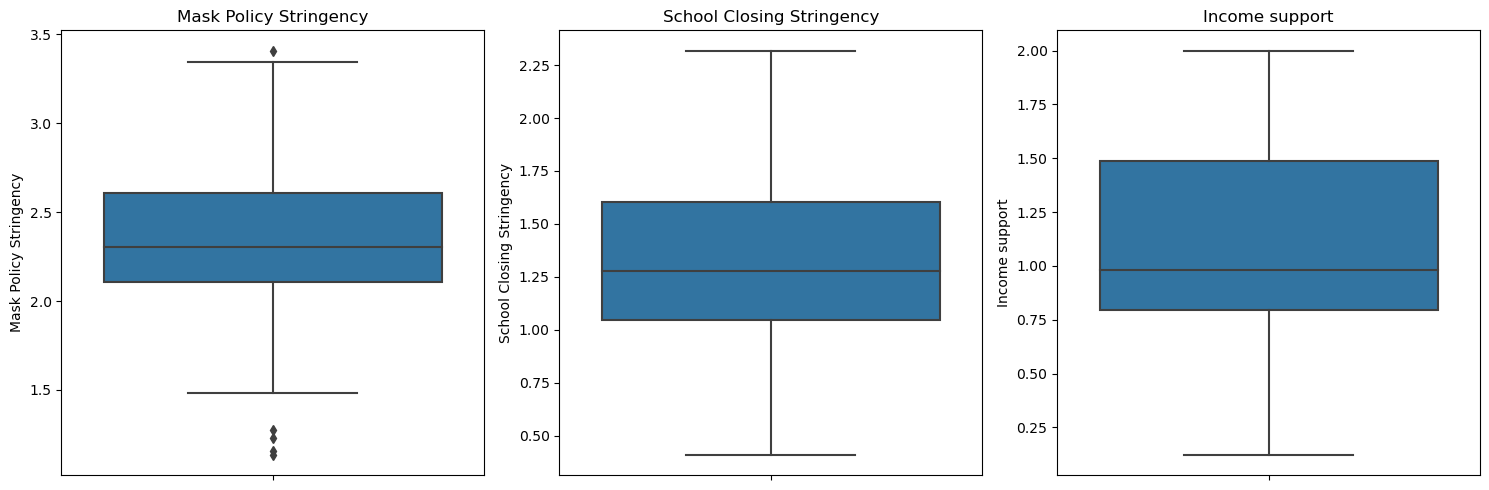

In [27]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Create a boxplot for each numerical column
plt.subplot(1, 3, 1)
sns.boxplot(y=df2['Mask Policy Stringency'])
plt.title('Mask Policy Stringency')

plt.subplot(1, 3, 2)
sns.boxplot(y=df2['School Closing Stringency'])
plt.title('School Closing Stringency')

plt.subplot(1, 3, 3)
sns.boxplot(y=df2['Income support'])
plt.title('Income support')

plt.tight_layout()
plt.show()

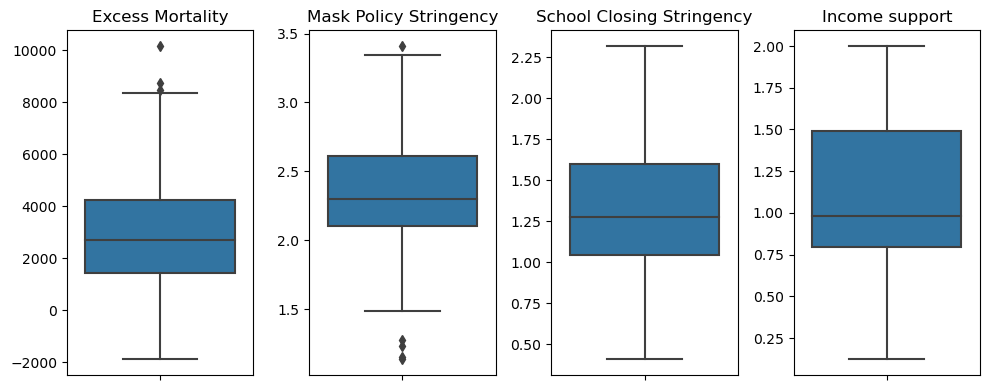

In [29]:
plt.figure(figsize=(10, 4))
# Create a boxplot for each numerical column
for i, feature in enumerate(['Excess Mortality', 'Mask Policy Stringency',
       'School Closing Stringency', 'Income support'], 1):
    ax = plt.subplot(1,4, i)
    sns.boxplot(y=df2[feature])
    plt.title(f'{feature}')
    ax.set_ylabel('')  # Remove the y-axis label

plt.tight_layout()
plt.show()

In [30]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [33]:
X = df2[['Mask Policy Stringency',
       'School Closing Stringency', 'Income support',
       ]]
y = df2['Excess Mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
acc = model.score(X_train, y_train)
print(f'The model accuracy is {acc:.4f}, The root mean squared error is {rmse:.4f}')
print(model.coef_)

The model accuracy is 0.0200, The root mean squared error is 1755.9422
[476.46475736 394.24142481 -73.56253976]


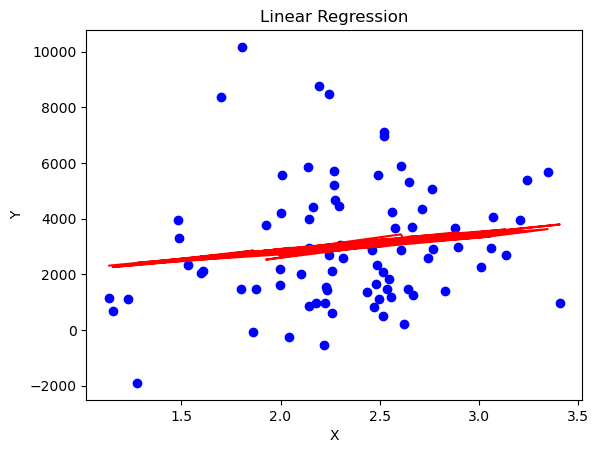

In [34]:
# Plot
model.fit(X, y)
df2['Predicted_Y'] = model.predict(X)
plt.scatter(df2['Mask Policy Stringency'], df2['Excess Mortality'], color='blue')  # Actual data points
plt.plot(df2['Mask Policy Stringency'], df2['Predicted_Y'], color='red')  # Regression line
plt.title('Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

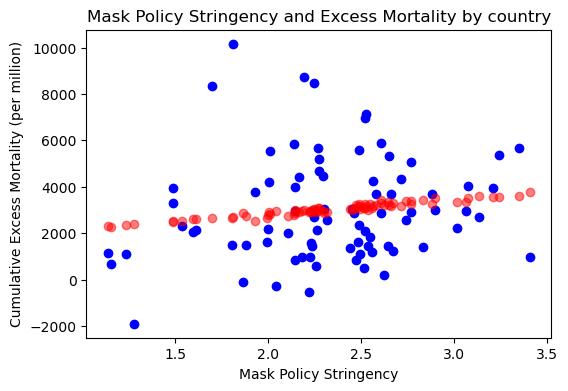

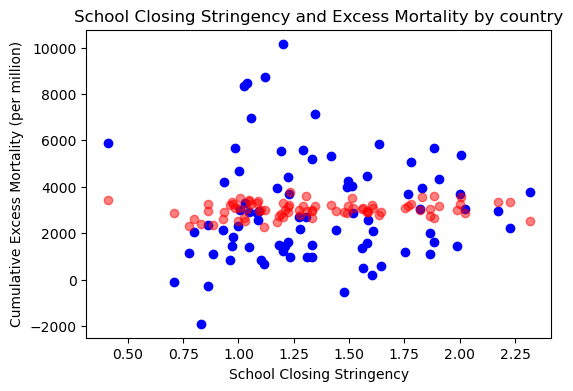

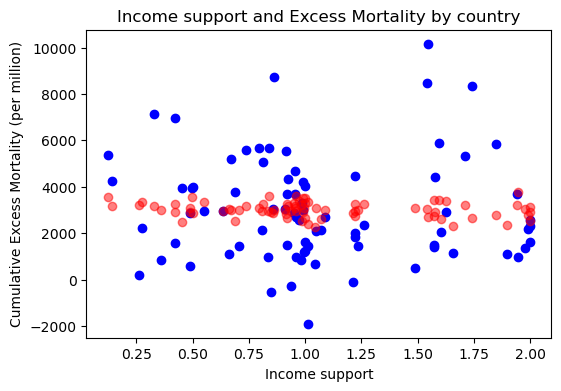

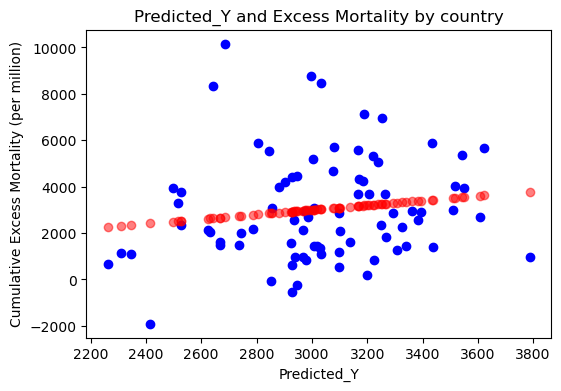

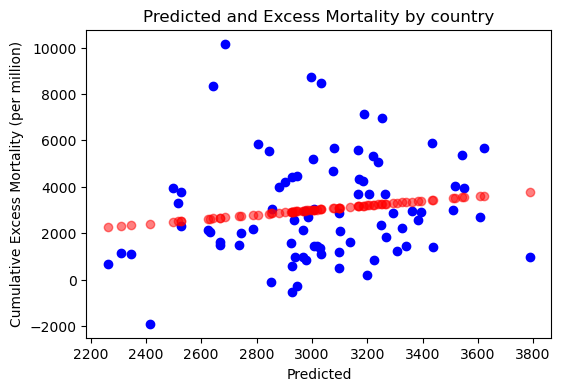

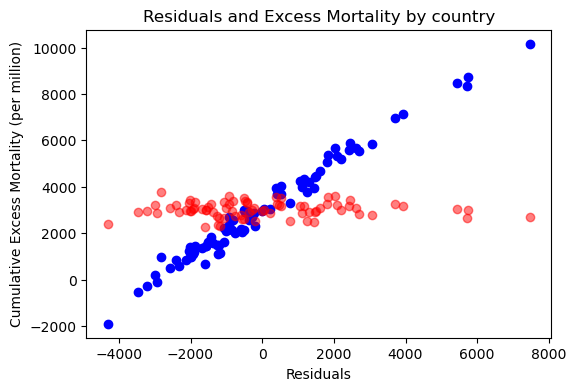

In [45]:
for column in df2.drop(['Excess Mortality', 'Country'], axis=1).columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(df2[column], df2['Excess Mortality'], color='blue')  # Actual data points
    plt.scatter(df2[column], df2['Predicted_Y'], color='red', alpha=0.5)  # Predicted values
    plt.title(f'{column} and Excess Mortality by country')
    plt.xlabel(column)
    plt.ylabel('Cumulative Excess Mortality (per million)')
    plt.show()

In [36]:
# Add a constant to the model (it's a best practice in statsmodels)

model2 = sm.OLS(y, X).fit()
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:       Excess Mortality   R-squared (uncentered):                   0.647
Model:                            OLS   Adj. R-squared (uncentered):              0.633
Method:                 Least Squares   F-statistic:                              47.61
Date:                Tue, 09 Jan 2024   Prob (F-statistic):                    1.36e-17
Time:                        22:35:20   Log-Likelihood:                         -739.84
No. Observations:                  81   AIC:                                      1486.
Df Residuals:                      78   BIC:                                      1493.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [41]:
df2.columns

Index(['Country', 'Excess Mortality', 'Mask Policy Stringency',
       'School Closing Stringency', 'Income support', 'Predicted_Y',
       'Predicted', 'Residuals'],
      dtype='object')

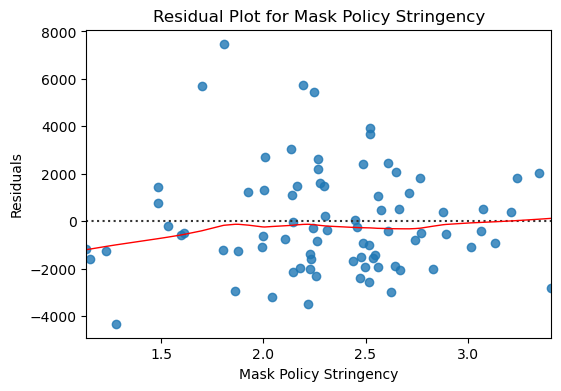

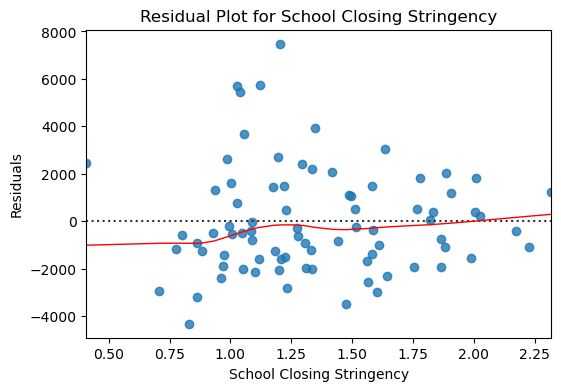

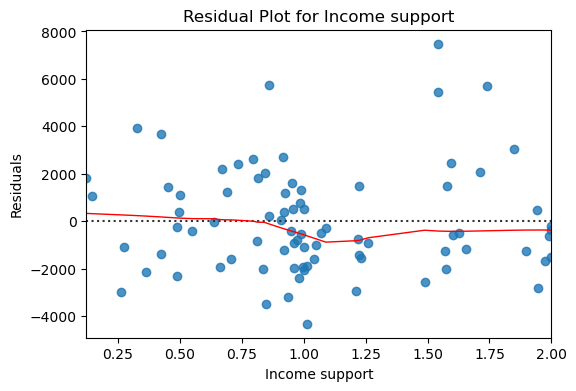

In [42]:
df2['Predicted'] = model.predict(X)
df2['Residuals'] = df2['Excess Mortality'] - df2['Predicted']

# Residual plot for each feature
for feature in ['Mask Policy Stringency',
       'School Closing Stringency', 'Income support']:
    plt.figure(figsize=(6, 4))
    sns.residplot(x=df2[feature], y=df2['Residuals'], lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.title(f'Residual Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.show()

In [ ]:
df2.to_csv(r"C:\Users\jdgoe\OneDrive\Uni - Official\Stats Project\ohboy 01.07.24.csv", index=False)